# Plate rheology

Add rheology parameters to the suduction dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import gplately

extent_globe = [-180, 180, -90, 90]

In [2]:
df = pd.read_csv("data/subduction_data.csv", index_col=0)

subduction_lon         = df['lon']
subduction_lat         = df['lat']
subduction_angle       = df['angle']
subduction_norm        = df['norm']
subduction_pid_sub     = df['pid_sub']
subduction_pid_over    = df['pid_over']
subduction_length      = df['length']
subduction_convergence = df['vel']
subduction_dip         = df['slab_dip']

## Spreading rate

The spreading rate controls the volatile influx into the plate. An increased abundance of volatile components, such as water and carbon, enhances the coupling between the subducting plate to the overriding plate. We sample the spreading rate grids at trench boundaries (i.e. the spreading rate which formed the seafloor now being subducted).

In [3]:
# define DataServer object
gdownload = gplately.DataServer("Clennett2020")

# download spreading rate grid at 0 Ma
spreadrate_grid = gdownload.get_spreading_rate_grid(0) * 1e-3 # convert to m/yr

# sample spreading rate grid at subduction zones
spreadrate_raster = gplately.Raster(array=spreadrate_grid, extent=extent_globe)
spreadrate_raster.fill_NaNs(overwrite=True)
spreadrate_interp = spreadrate_raster.interpolate(subduction_lon, subduction_lat)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


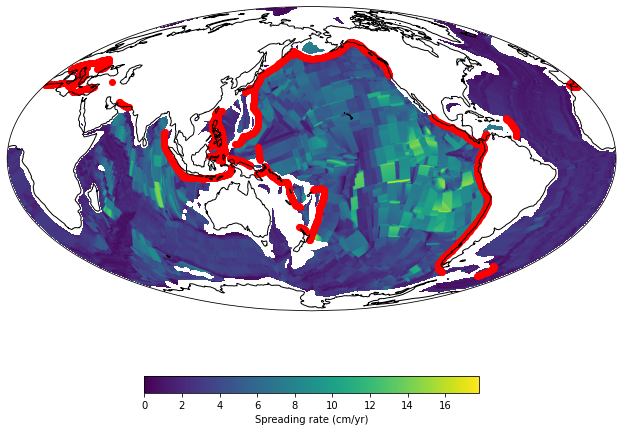

In [4]:
proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

im = ax.imshow(spreadrate_grid*100, origin='lower', transform=ccrs.PlateCarree(), vmin=0)

sc = ax.scatter(subduction_lon, subduction_lat, c='r', transform=ccrs.PlateCarree())

ax.coastlines()
fig.colorbar(im, orientation='horizontal', shrink=0.4, label='Spreading rate (cm/yr)')

## Density

Calculate the mean density of oceanic lithosphere. We assume uniform densities of the crust and mantle lithosphere, $\rho_c$ and $\rho_m$, as well as a uniform crustal thickness, $h_c$. The average density is calculated using a weighted average where older, thicker lithosphere is higher density than younger lithosphere.

The __buoyancy__ is related to the difference between the density of the plate and the asthenosphere, $\Delta \rho$

In [5]:
h_slab = df['slab_thickness'].to_numpy() + 1e-3

h_c = 7e3 # thickness of crust
h_s = 43e3 # thickness of spinel field
h_g = 55e3 # thickness of garnet field
h_total = h_c + h_s + h_g

rho_a = 3300
rho_c = 2900 # density of crust
rho_s = 3330 # density of spinel
rho_g0, rho_g1 = 3370, 3340 # density of garnet (upper, lower)

h_c = np.minimum(h_slab, h_c)
h_s = np.minimum(h_slab - h_c, h_s)
h_g = h_slab - h_c - h_s

# find the density of the garnet field
# a linear decay from g0 to g1 from 0 to 55+ km thickness
def rho_garnet(h):
    m = -(3370 - 3340)/55e3
    c = 3370
    return h*m + c

rho_g = 0.5*(rho_g0 + rho_garnet(h_g))

rho_plate = (rho_c*h_c + rho_s*h_s + rho_g*h_g)/(h_c + h_s + h_g)
delta_rho = rho_plate - rho_a

Text(0, 0.5, 'Relative density (kg/m3)')

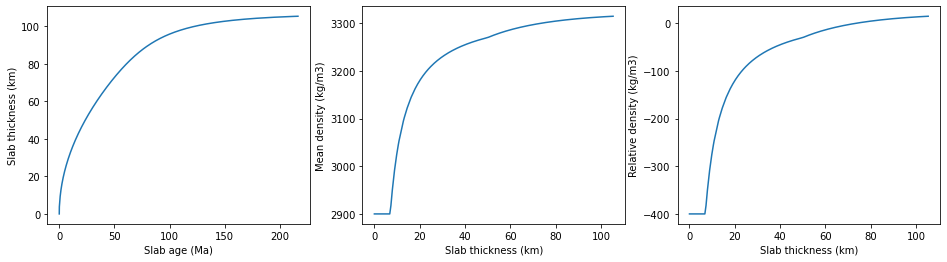

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))

idx = h_slab.argsort()

ax1.plot(df['slab_age'][idx], df['slab_thickness'][idx]*1e-3)
ax2.plot(df['slab_thickness'][idx]*1e-3, rho_plate[idx])
ax3.plot(df['slab_thickness'][idx]*1e-3, delta_rho[idx])

ax1.set_xlabel('Slab age (Ma)')
ax1.set_ylabel('Slab thickness (km)')
ax2.set_xlabel('Slab thickness (km)')
ax2.set_ylabel('Mean density (kg/m3)')
ax3.set_xlabel('Slab thickness (km)')
ax3.set_ylabel('Relative density (kg/m3)')

There is a little heel at very thin young slabs because the ocean crust is the only component of seafloor to have formed, which has a constant density of $\rho_c = 2900$ kg/m$^3$.

## Save

In [7]:
df = df.assign(density=rho_plate, relative_density=delta_rho, spreading_rate=spreadrate_interp)
df.to_csv('data/subduction_data.csv')